# Imports

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Processing MNIST

In [ ]:

print("Loading and preprocessing data...")
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Split data into development and training sets
data_dev = data[0:1000].T
y_dev = data_dev[0]
x_dev = data_dev[1:n]
x_dev = x_dev / 255.0  #for normalization

data_train = data[1000:m].T
y_train = data_train[0]
x_train = data_train[1:n]
x_train = x_train / 255.0   #for normalization

print(f"Training set: {x_train.shape[1]} examples")
print(f"Development set: {x_dev.shape[1]} examples")


Loading and preprocessing data...
Training set: 41000 examples
Development set: 1000 examples


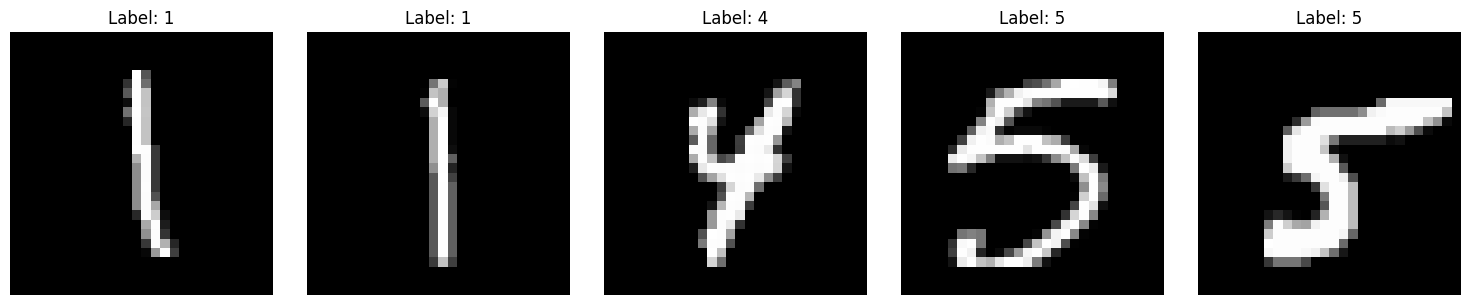

In [ ]:
# Visualize some examples
def visualize_examples(X, y, num_examples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X[:, i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {int(y[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize
visualize_examples(x_train, y_train)


In [ ]:
# Neural Network Functions
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        #He initialization
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def one_hot_encode(y, num_classes=10):
    
    m = y.size
    one_hot = np.zeros((num_classes, m))
    one_hot[y.astype(int), np.arange(m)] = 1
    return one_hot



In [ ]:
def forward_propagation(X, parameters):
    cache = {}
    cache['Z1'] = parameters['W1'].dot(X) + parameters['b1']
    cache['A1'] = relu(cache['Z1'])
    cache['Z2'] = parameters['W2'].dot(cache['A1']) + parameters['b2']
    cache['A2'] = relu(cache['Z2'])
    cache['Z3']=parameters['W3'].dot(cache['A2'])+parameters['b3']
    cache['A3'] = softmax(cache['Z3'])
    cache['X'] = X
    return cache
    
def compute_cost(A3, Y):
  
    Y_one_hot = one_hot_encode(Y, num_classes=A3.shape[0])  # force depth=10
    m = Y_one_hot.shape[1]
    cost = -np.sum(Y_one_hot * np.log(A3 + 1e-8)) / m
    return cost

def backward_propagation(parameters, cache, Y):
    m = Y.size
    A3 = cache['A3']
    Y_one_hot = one_hot_encode(Y, num_classes=A3.shape[0])  # one-hot labels

    # Output layer
    dZ3 = A3 - Y_one_hot
    dW3 = (1/m) * dZ3.dot(cache['A2'].T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # 2nd hidden layer
    dA2 = parameters['W3'].T.dot(dZ3)
    dZ2 = dA2 * relu_derivative(cache['Z2'])
    dW2 = (1/m) * dZ2.dot(cache['A1'].T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # 1st hidden layer
    dA1 = parameters['W2'].T.dot(dZ2)
    dZ1 = dA1 * relu_derivative(cache['Z1'])
    dW1 = (1/m) * dZ1.dot(cache['X'].T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}


In [ ]:
# Helper functions
def get_predictions(A3):
    return np.argmax(A3, axis=0)

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y) * 100

def create_minibatches(X, Y, batch_size):
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[permutation]
    num_complete_minibatches = m // batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size: (k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[k * batch_size: (k + 1) * batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    return mini_batches


In [ ]:
# Optimizers
def sgd_update(parameters, gradients, learning_rate):
    for key in parameters:
        parameters[key] = parameters[key] - learning_rate * gradients["d" + key]
    return parameters, {}

def momentum_update(parameters, gradients, velocity, beta=0.9, learning_rate=0.01):
    if not velocity:
        velocity = {key: np.zeros_like(parameters[key]) for key in parameters}
    for key in parameters:
        velocity[key] = beta * velocity[key] + (1 - beta) * gradients["d" + key]
        parameters[key] = parameters[key] - learning_rate * velocity[key]
    return parameters, velocity

def rmsprop_update(parameters, gradients, squared_grad, beta=0.999, learning_rate=0.01, epsilon=1e-8):
    if not squared_grad:
        squared_grad = {key: np.zeros_like(parameters[key]) for key in parameters}
    for key in parameters:
        squared_grad[key] = beta * squared_grad[key] + (1 - beta) * (gradients["d" + key] ** 2)
        parameters[key] = parameters[key] - learning_rate * gradients["d" + key] / (np.sqrt(squared_grad[key]) + epsilon)
    return parameters, squared_grad

def adam_update(parameters, gradients, velocity, squared_grad, t, beta1=0.9, beta2=0.999, learning_rate=0.01, epsilon=1e-8):
    if not velocity:
        velocity = {key: np.zeros_like(parameters[key]) for key in parameters}
        squared_grad = {key: np.zeros_like(parameters[key]) for key in parameters}
    for key in parameters:
        velocity[key] = beta1 * velocity[key] + (1 - beta1) * gradients["d" + key]
        squared_grad[key] = beta2 * squared_grad[key] + (1 - beta2) * (gradients["d" + key] ** 2)
        velocity_corrected = velocity[key] / (1 - beta1 ** t)
        squared_grad_corrected = squared_grad[key] / (1 - beta2 ** t)
        parameters[key] = parameters[key] - learning_rate * velocity_corrected / (np.sqrt(squared_grad_corrected) + epsilon)
    return parameters, velocity, squared_grad


In [ ]:
# Training function
def train_model(X, Y, X_dev, Y_dev, layers_dims, optimizer="sgd", learning_rate=0.01, 
               mini_batch_size=64, beta1=0.9, beta2=0.999, epsilon=1e-8, 
               num_epochs=100, print_interval=10):
    
    start_time = time.time()
    parameters = initialize_parameters(layers_dims)
    velocity, squared_grad = {}, {}
    t = 0
    train_costs, dev_costs, train_accuracies, dev_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        epoch_cost = 0
        mini_batches = create_minibatches(X, Y, mini_batch_size)
        for mini_batch in mini_batches:
            mini_batch_X, mini_batch_Y = mini_batch
            t += 1
            cache = forward_propagation(mini_batch_X, parameters)
            mini_batch_cost = compute_cost(cache['A3'], mini_batch_Y)
            epoch_cost += mini_batch_cost / len(mini_batches)
            gradients = backward_propagation(parameters, cache, mini_batch_Y)
            if optimizer == "sgd":
                parameters, _ = sgd_update(parameters, gradients, learning_rate)
            elif optimizer == "momentum":
                parameters, velocity = momentum_update(parameters, gradients, velocity, beta1, learning_rate)
            elif optimizer == "rmsprop":
                parameters, squared_grad = rmsprop_update(parameters, gradients, squared_grad, beta2, learning_rate)
            elif optimizer == "adam":
                parameters, velocity, squared_grad = adam_update(parameters, gradients, velocity, squared_grad, t, beta1, beta2, learning_rate, epsilon)
        
        if (epoch + 1) % print_interval == 0 or epoch == 0:
            train_cache = forward_propagation(X, parameters)
            train_cost = compute_cost(train_cache['A3'], Y)
            train_accuracy = get_accuracy(get_predictions(train_cache['A3']), Y)
            dev_cache = forward_propagation(X_dev, parameters)
            dev_cost = compute_cost(dev_cache['A3'], Y_dev)
            dev_accuracy = get_accuracy(get_predictions(dev_cache['A3']), Y_dev)
            print(f"Epoch {epoch+1}/{num_epochs} | Cost: {epoch_cost:.4f} | Train Acc: {train_accuracy:.2f}% | Dev Acc: {dev_accuracy:.2f}%")
            train_costs.append(train_cost)
            dev_costs.append(dev_cost)
            train_accuracies.append(train_accuracy)
            dev_accuracies.append(dev_accuracy)

    training_time = time.time() - start_time
    final_dev_predictions = get_predictions(forward_propagation(X_dev, parameters)['A3'])
    conf_matrix = confusion_matrix(Y_dev, final_dev_predictions)
    
    return {
        "parameters": parameters, "train_costs": train_costs, "dev_costs": dev_costs,
        "train_accuracies": train_accuracies, "dev_accuracies": dev_accuracies,
        "final_train_accuracy": get_accuracy(get_predictions(forward_propagation(X, parameters)['A3']), Y),
        "final_dev_accuracy": get_accuracy(final_dev_predictions, Y_dev),
        "confusion_matrix": conf_matrix, "training_time": training_time, "predictions": final_dev_predictions
    }


In [ ]:
# Set up network architecture
layers_dims = [784, 512,128, 10]

# Define hyperparameters for each optimizer
optimizers = {
    "sgd": {"learning_rate": 0.1},
    "momentum": {"learning_rate": 0.01, "beta1": 0.9},
    "rmsprop": {"learning_rate": 0.001, "beta2": 0.999},
    "adam": {"learning_rate": 0.001, "beta1": 0.9, "beta2": 0.999}
}

# Train with each optimizer
results = {}
print("\nStarting training with different optimizers...\n")
for opt_name, opt_params in optimizers.items():
    print(f"\n{'='*50}\nTraining with {opt_name.upper()}\n{'='*50}")
    results[opt_name] = train_model(
        X=x_train, Y=y_train, X_dev=x_dev, Y_dev=y_dev,
        layers_dims=layers_dims, optimizer=opt_name,
        learning_rate=opt_params.get("learning_rate", 0.01),
        beta1=opt_params.get("beta1", 0.9),
        beta2=opt_params.get("beta2", 0.999),
        num_epochs=50, print_interval=5
    )



Starting training with different optimizers...


Training with SGD
Epoch 1/50 | Cost: 0.3482 | Train Acc: 94.16% | Dev Acc: 93.70%
Epoch 5/50 | Cost: 0.0613 | Train Acc: 98.73% | Dev Acc: 97.10%
Epoch 10/50 | Cost: 0.0196 | Train Acc: 99.72% | Dev Acc: 97.60%
Epoch 15/50 | Cost: 0.0062 | Train Acc: 99.98% | Dev Acc: 98.20%
Epoch 20/50 | Cost: 0.0026 | Train Acc: 100.00% | Dev Acc: 98.00%
Epoch 25/50 | Cost: 0.0017 | Train Acc: 100.00% | Dev Acc: 98.10%
Epoch 30/50 | Cost: 0.0012 | Train Acc: 100.00% | Dev Acc: 97.90%
Epoch 35/50 | Cost: 0.0009 | Train Acc: 100.00% | Dev Acc: 98.10%
Epoch 40/50 | Cost: 0.0007 | Train Acc: 100.00% | Dev Acc: 98.00%
Epoch 45/50 | Cost: 0.0006 | Train Acc: 100.00% | Dev Acc: 98.10%
Epoch 50/50 | Cost: 0.0005 | Train Acc: 100.00% | Dev Acc: 98.10%

Training with MOMENTUM
Epoch 1/50 | Cost: 0.9005 | Train Acc: 88.35% | Dev Acc: 87.60%
Epoch 5/50 | Cost: 0.2442 | Train Acc: 93.48% | Dev Acc: 92.20%
Epoch 10/50 | Cost: 0.1719 | Train Acc: 95.45% | Dev Acc: 94

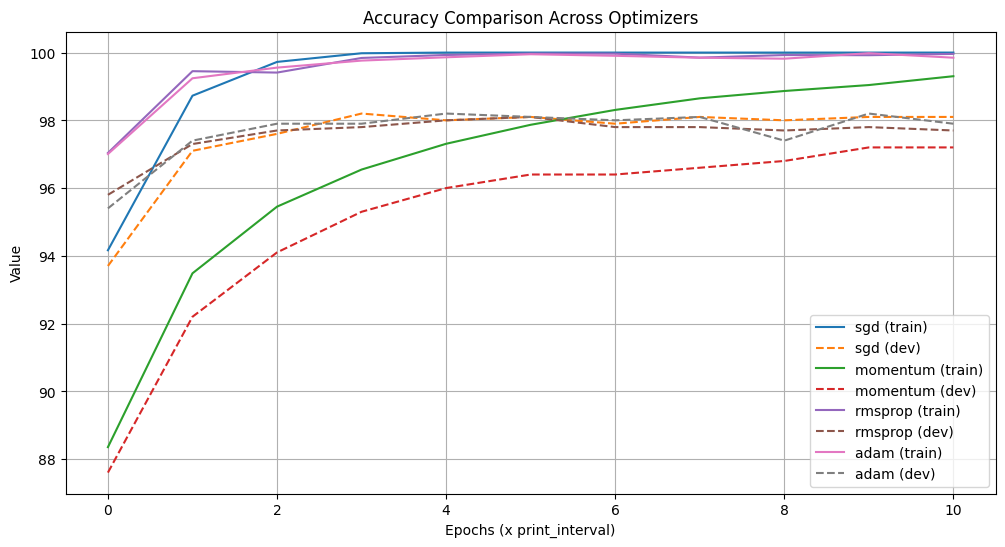

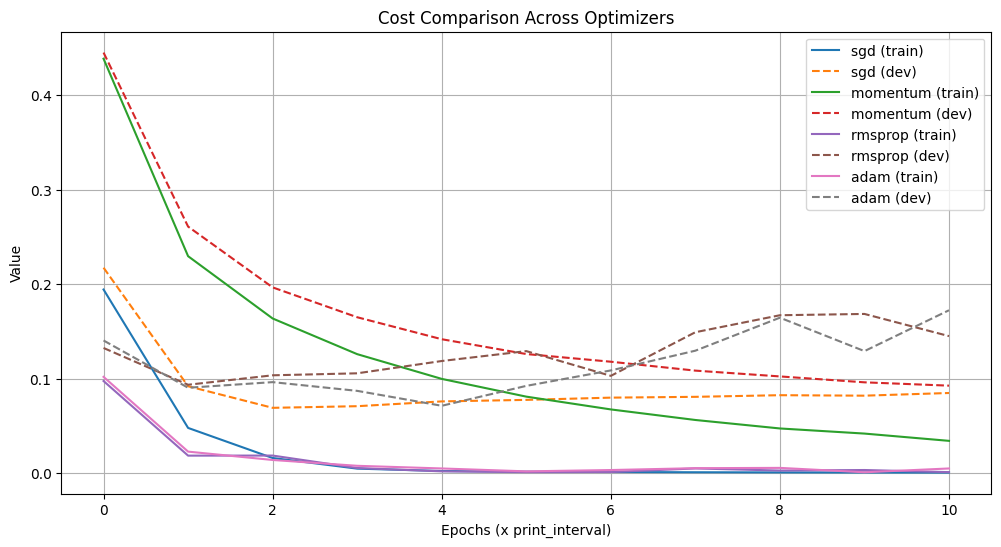

In [ ]:
# Plotting functions
def plot_metrics_comparison(results, metric_name, title):
    plt.figure(figsize=(12, 6))
    for opt_name, result in results.items():
        if metric_name == "costs":
            plt.plot(result["train_costs"], label=f"{opt_name} (train)")
            plt.plot(result["dev_costs"], label=f"{opt_name} (dev)", linestyle="--")
        else:
            plt.plot(result["train_accuracies"], label=f"{opt_name} (train)")
            plt.plot(result["dev_accuracies"], label=f"{opt_name} (dev)", linestyle="--")
    plt.title(title)
    plt.xlabel("Epochs (x print_interval)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot training curves
plot_metrics_comparison(results, "accuracies", "Accuracy Comparison Across Optimizers")
plot_metrics_comparison(results, "costs", "Cost Comparison Across Optimizers")


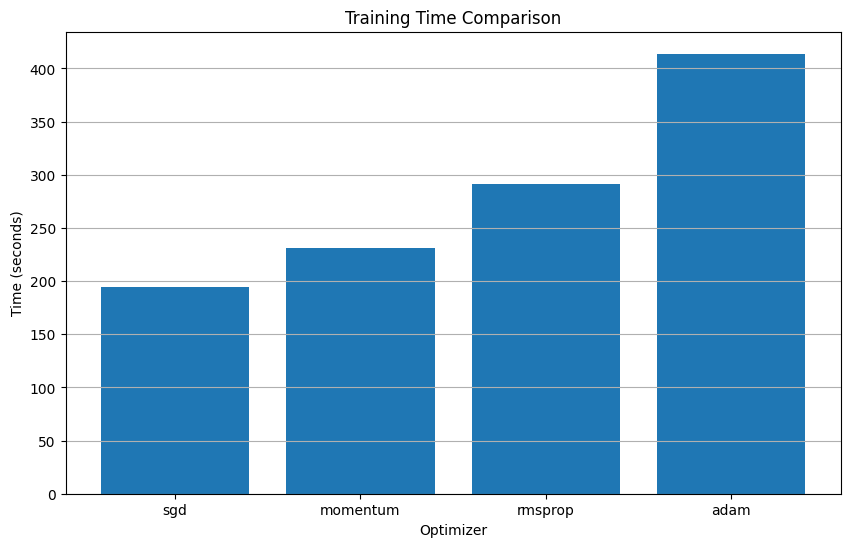

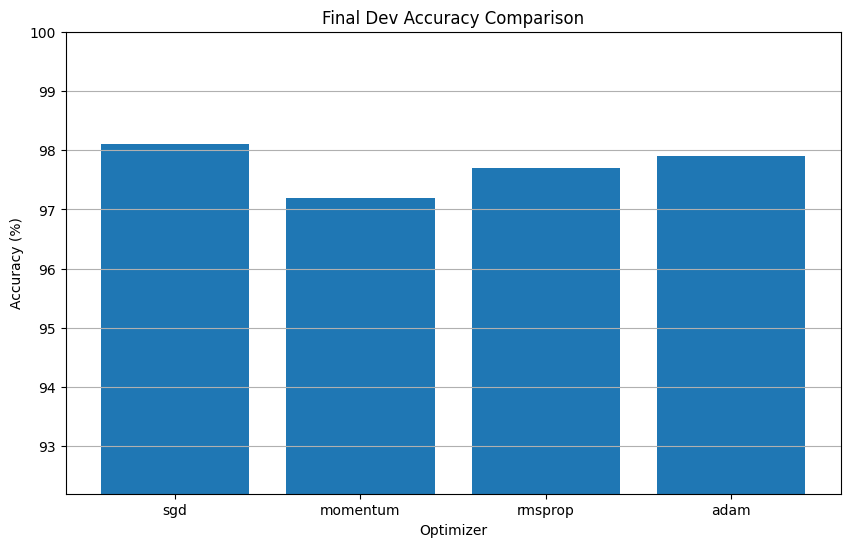

In [ ]:
# Compare training times and final accuracies
training_times = {opt: result["training_time"] for opt, result in results.items()}
final_accuracies = {opt: result["final_dev_accuracy"] for opt, result in results.items()}

plt.figure(figsize=(10, 6))
plt.bar(training_times.keys(), training_times.values())
plt.title("Training Time Comparison")
plt.xlabel("Optimizer")
plt.ylabel("Time (seconds)")
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(final_accuracies.keys(), final_accuracies.values())
plt.title("Final Dev Accuracy Comparison")
plt.xlabel("Optimizer")
plt.ylabel("Accuracy (%)")
plt.ylim([min(final_accuracies.values()) - 5, 100])
plt.grid(axis='y')
plt.show()



Best optimizer: SGD with 98.10% accuracy


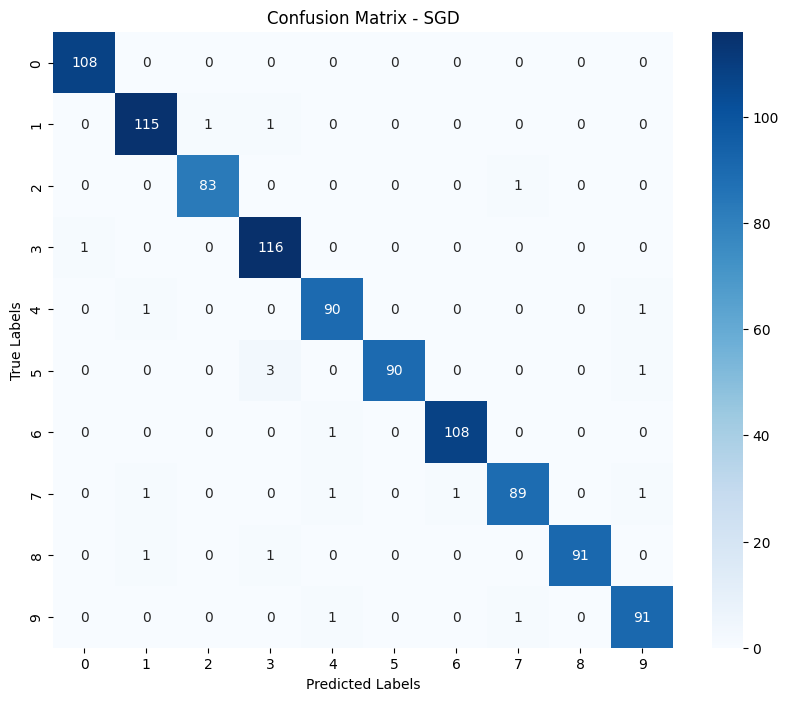

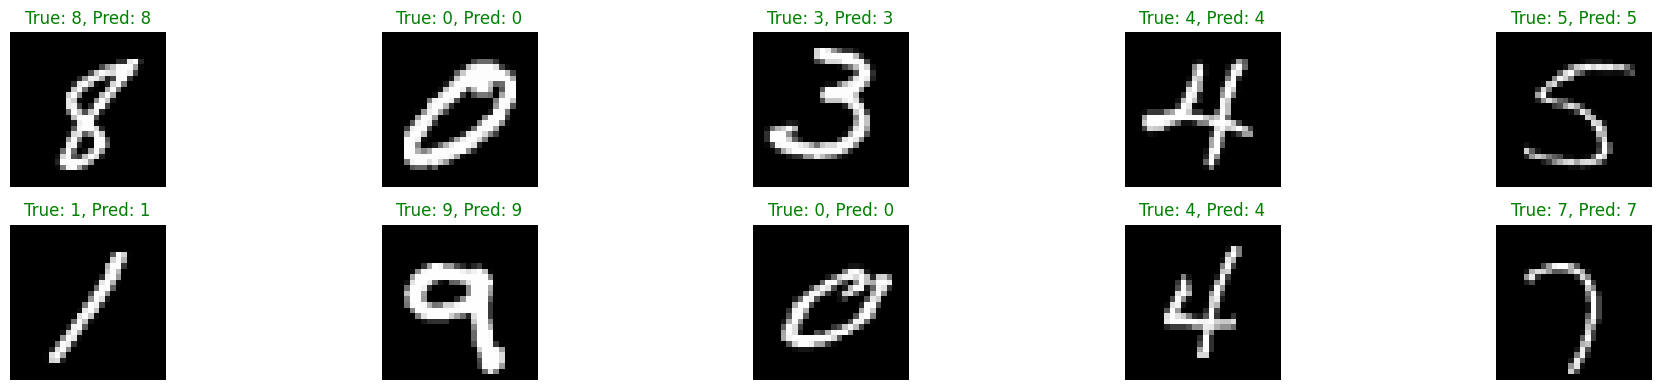

In [ ]:
# Show confusion matrix for best model
best_optimizer = max(final_accuracies, key=final_accuracies.get)
print(f"\nBest optimizer: {best_optimizer.upper()} with {final_accuracies[best_optimizer]:.2f}% accuracy")

plt.figure(figsize=(10, 8))
sns.heatmap(results[best_optimizer]["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_optimizer.upper()}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, num_examples=10):
    indices = np.random.choice(X.shape[1], num_examples, replace=False)
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices):
        plt.subplot(2, num_examples//2, i+1)
        plt.imshow(X[:, idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {int(y_true[idx])}, Pred: {int(y_pred[idx])}", color='green' if y_true[idx]==y_pred[idx] else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

best_predictions = results[best_optimizer]["predictions"]
visualize_predictions(x_dev, y_dev, best_predictions)


In [ ]:
# 🧪 Cell 13: Test‐set prediction and submission
import pandas as pd
import numpy as np

# 1. Load test data
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test = test_df.values.T   # shape (784, num_examples)
X_test = X_test / 255.0      # normalize

# 2. Forward propagate using best model
best_params = results[best_optimizer]['parameters']
cache_test = forward_propagation(X_test, best_params)
A3_test = cache_test['A3']

# 3. Get predictions
predictions_test = np.argmax(A3_test, axis=0)  # shape (num_examples,)

# 4. Build submission DataFrame
submission = pd.DataFrame({
    'ImageId': np.arange(1, predictions_test.size + 1),
    'Label': predictions_test
})

# 5. Save to CSV
submission.to_csv('mnist_submission.csv', index=False)
print("Submission file 'mnist_submission.csv' created!")


Submission file 'mnist_submission.csv' created!
